In [1]:
from collections import defaultdict
from math import erf
from statistics import NormalDist

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib notebook

In [2]:
years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/years.csv")
team_years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/team_years.csv")
events_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/events.csv")
matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/matches.csv")
team_matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/team_matches.csv")

In [3]:
matches_df = pd.merge(matches_df, events_df[["key", "week"]], left_on="event", right_on="key").rename(columns={"key_x": "key"}).drop(columns=["key_y"])

In [4]:
class ScorePred:
    def __init__(self, red_pred, red_sd, blue_pred, blue_sd):
        self.red_pred = red_pred
        self.red_sd = red_sd
        self.blue_pred = blue_pred
        self.blue_sd = blue_sd
        
    def __add__(self, other):
        return ScorePred(
            self.red_pred + other.red_pred, 
            self.red_sd + other.red_sd, 
            self.blue_pred + other.blue_pred, 
            self.blue_sd + other.blue_sd
        )
    
    def __rmul__(self, other):
        return ScorePred(
            other * self.red_pred,
            other * self.red_sd,
            other * self.blue_pred,
            other * self.blue_sd,
        )
        
        
class Pred:
    def __init__(self, auto_pred, teleop_pred, endgame_pred, win_prob):
        self.auto_pred = auto_pred
        self.teleop_pred = teleop_pred
        self.endgame_pred = endgame_pred
        self.win_prob = win_prob
        
        
class ModelStats:
    def __init__(self, foul_rate):
        self.win_prob = []
        self.score_pred = []
        
        self.foul_rate = foul_rate
        
    def record_stats(self, match, pred):
        win_prob = pred.win_prob
        winner = {"blue": 0, "red": 1, "draw": 0.5}[match.winner]
        
        conf = max(win_prob, 1 - win_prob)
        acc = (win_prob > 0.5) == winner
        mse = (winner - win_prob) ** 2
        ll = -1 * (winner * np.log(win_prob) + (1 - winner) * np.log(1 - win_prob))
        
        common = {"week": match.week, "event": match.event, "playoff": match.playoff, "key": match.key}
        
        self.win_prob.append({
            **common, "winner": match.winner, "win_prob": win_prob, "conf": conf, "acc": acc, "mse": mse, "ll": ll,
        })
        
        auto_pred, teleop_pred, endgame_pred = pred.auto_pred, pred.teleop_pred, pred.endgame_pred
        total_pred = (1 + self.foul_rate) * (auto_pred + teleop_pred + endgame_pred)
        for label, alliance, score, pred, sd, in [
            ("auto", "red", match.red_auto, auto_pred.red_pred, auto_pred.red_sd),
            ("auto", "blue", match.blue_auto, auto_pred.blue_pred, auto_pred.blue_sd),
            ("teleop", "red", match.red_teleop, teleop_pred.red_pred, teleop_pred.red_sd),
            ("teleop", "blue", match.blue_teleop, teleop_pred.blue_pred, teleop_pred.blue_sd),
            ("endgame", "red", match.red_endgame, endgame_pred.red_pred, endgame_pred.red_sd),
            ("endgame", "blue", match.blue_endgame, endgame_pred.blue_pred, endgame_pred.blue_sd),
            ("total", "red", match.red_score, total_pred.red_pred, total_pred.red_sd),
            ("total", "blue", match.blue_score, total_pred.blue_pred, total_pred.blue_sd),
        ]:
            mse = (score - pred) ** 2
            self.score_pred.append({
                "label": label, **common, "alliance": alliance, "score": score, "pred": pred, "mse": mse, "sd": sd,
            })
            
    def print_stats(self):
        win_prob_df = pd.DataFrame(self.win_prob)
        score_pred_df = pd.DataFrame(self.score_pred)
        score_pred_df = score_pred_df[score_pred_df.label == "total"]
        
        def agg_win_prob(name, _filter):
            temp_df = _filter(win_prob_df)
            temp = temp_df.agg({"event": "count", "conf": "mean", "acc": "mean", "mse": "mean", "ll": "mean"})
            rounded = [f"{temp.conf:.4f}", f"{temp.acc:.4f}", f"{temp.mse:.4f}", f"{temp.ll:.4f}"]
            print("\t".join([name + "\t", str(int(temp.event))] + rounded))
        
        def agg_score_pred(name, _filter):
            temp_df = _filter(score_pred_df)
            temp = temp_df.agg({"event": "count", "mse": "mean", "sd": "mean"})
            rounded = [f"{temp.mse:.2f}", f"{temp.sd:.3f}"]
            print("\t".join([name + "\t", str(int(temp.event))] + rounded))
            
        print("Win Prob")
        print("Category\tCount\tConf\tAcc\tMSE\tLL")
        for week in range(1, 9):
            agg_win_prob("Week " + str(week), lambda x: x[(x.week == week) & (x.playoff == False)])
        agg_win_prob("Quals", lambda x: x[(x.playoff == False)])
        agg_win_prob("Elims", lambda x: x[(x.playoff == True)])
        print()
        
        print("Score Pred")
        print("Category\tCount\tMSE\tSD")
        for week in range(1, 9):
            agg_score_pred("Week " + str(week), lambda x: x[(x.week == week) & (x.playoff == False)])
        agg_score_pred("Quals", lambda x: x[(x.playoff == False)])
        agg_score_pred("Elims", lambda x: x[(x.playoff == True)])
        print()

In [5]:
# TUNABLE

var_n = 1000
prior_sd_ratio = 1 / 3

def margin_func(x):
    return min(1, max(0, 1 / 24 * (x - 12)))

def percent_func(x):
    return min(0.5, max(0.3, 0.5 - 0.2 / 6 * (x - 6)))

def sum_func(arr, mean):
    rate = 0.2
    x = sum(arr) * (1 - rate) + max(arr) * rate
    return min(x, 2 * mean + (1 - rate) * (x - 2 * mean))


# REQUIRED CONSTANTS

config = {
    2017: [179, 70, 32, 76, 63, 8],
    2018: [265, 107, 21, 185, 41, 16],
    2019: [45, 17, 11, 21, 11, 2],
    2022: [41, 22, 11.5, 15.5, 11.5, 2.5],
}

YEAR = 2022
MEAN, SD, AUTO_MEAN, TELEOP_MEAN, ENDGAME_MEAN, FOULS_MEAN = config[YEAR]
FOUL_RATE = FOULS_MEAN / MEAN


# HELPER

def win_prob_func(mu, sigma):
    return 0.5 - 0.5 * erf(-mu / (sigma * 2 ** 0.5))


# MAIN CODE

model_stats = ModelStats(FOUL_RATE)

# note: for whole alliance, not individual team
auto_var = var_n * (prior_sd_ratio * AUTO_MEAN) ** 2
teleop_var = var_n * (prior_sd_ratio * TELEOP_MEAN) ** 2
endgame_var = var_n * (prior_sd_ratio * ENDGAME_MEAN) ** 2
total_var = var_n * (prior_sd_ratio * MEAN) ** 2

def sd_func(variance):
    return (variance / var_n) ** 0.5

counts = defaultdict(lambda: 0)
auto_ratings = defaultdict(lambda: [AUTO_MEAN / 3])
teleop_ratings = defaultdict(lambda: [TELEOP_MEAN / 3])
endgame_ratings = defaultdict(lambda: [ENDGAME_MEAN / 3])
total_ratings = defaultdict(lambda: [MEAN / 3])
for _, t in team_years_df[(team_years_df.year == YEAR)].iterrows():
    team, prior = t.team, MEAN / 3 + (t.elo_start - 1500) / 250 * SD
    auto_ratings[team] = [prior * AUTO_MEAN / MEAN]
    teleop_ratings[team] =[prior * TELEOP_MEAN / MEAN]
    endgame_ratings[team] = [prior * ENDGAME_MEAN / MEAN]
    total_ratings[team] = [prior]

event_matches_df = matches_df[(matches_df.year == YEAR) & (matches_df.status == "Completed")].sort_values(by=["time"])
for _, match in event_matches_df.iterrows():
    red_teams = [int(x) for x in match.red.split(",")]
    blue_teams = [int(x) for x in match.blue.split(",")]
    
    red_auto_preds = [auto_ratings[t][-1] for t in red_teams]
    blue_auto_preds = [auto_ratings[t][-1] for t in blue_teams]
    red_auto_pred, blue_auto_pred = sum_func(red_auto_preds, AUTO_MEAN), sum_func(blue_auto_preds, AUTO_MEAN)
    
    red_teleop_preds = [teleop_ratings[t][-1] for t in red_teams]
    blue_teleop_preds = [teleop_ratings[t][-1] for t in blue_teams]
    red_teleop_pred, blue_teleop_pred = sum_func(red_teleop_preds, TELEOP_MEAN), sum_func(blue_teleop_preds, TELEOP_MEAN)
    
    red_endgame_preds = [endgame_ratings[t][-1] for t in red_teams]
    blue_endgame_preds = [endgame_ratings[t][-1] for t in blue_teams]
    red_endgame_pred, blue_endgame_pred = sum_func(red_endgame_preds, ENDGAME_MEAN), sum_func(blue_endgame_preds, ENDGAME_MEAN)
    
    red_preds = [total_ratings[t][-1] for t in red_teams]
    blue_preds = [total_ratings[t][-1] for t in blue_teams]
    red_pred, blue_pred = sum_func(red_preds, MEAN), sum_func(blue_preds, MEAN)
    
    auto_sd, teleop_sd, endgame_sd, total_sd = sd_func(auto_var), sd_func(teleop_var), sd_func(endgame_var), sd_func(total_var)
    win_prob = win_prob_func(red_pred - blue_pred, total_sd * (2 ** 0.5))
    
    pred = Pred(
        auto_pred=ScorePred(red_pred=red_auto_pred, red_sd=auto_sd, blue_pred=blue_auto_pred, blue_sd=auto_sd),
        teleop_pred=ScorePred(red_pred=red_teleop_pred, red_sd=teleop_sd, blue_pred=blue_teleop_pred, blue_sd=teleop_sd),
        endgame_pred=ScorePred(red_pred=red_endgame_pred, red_sd=endgame_sd, blue_pred=blue_endgame_pred, blue_sd=endgame_sd),
        win_prob=win_prob
    )
    model_stats.record_stats(match, pred)
    
    var_n += 2
    auto_var += (match.red_auto - red_auto_pred) ** 2 + (match.blue_auto - blue_auto_pred) ** 2
    teleop_var += (match.red_teleop - red_teleop_pred) ** 2 + (match.blue_auto - blue_teleop_pred) ** 2
    endgame_var += (match.red_endgame - red_endgame_pred) ** 2 + (match.blue_endgame - blue_endgame_pred) ** 2
    total_var += (match.red_no_fouls - red_pred) ** 2 + (match.blue_no_fouls - blue_pred) ** 2
    
    for teams, my_score, opp_score, my_preds, my_pred, opp_pred in [
        (red_teams, match.red_no_fouls, match.blue_no_fouls, red_preds, red_pred, blue_pred),
        (blue_teams, match.blue_no_fouls, match.red_no_fouls, blue_preds, blue_pred, red_pred),
    ]:
        for team, mean in zip(teams, my_preds):
            margin_factor = margin_func(counts[team])
            percent, weight = percent_func(counts[team]), 1/4 if match.playoff else 1
            error = ((my_score - my_pred) + margin_factor * (opp_pred - opp_score)) / (1 + margin_factor)
            total_ratings[team].append(total_ratings[team][-1] + percent * weight * error / 3)
        
    for teams, score, pred, preds, ratings_dict in [
        (red_teams, match.red_auto, red_auto_pred, red_auto_preds, auto_ratings),
        (blue_teams, match.blue_auto, blue_auto_pred, blue_auto_preds, auto_ratings),
        (red_teams, match.red_teleop, red_teleop_pred, red_teleop_preds, teleop_ratings),
        (blue_teams, match.blue_teleop, blue_teleop_pred, blue_teleop_preds, teleop_ratings),
        (red_teams, match.red_endgame, red_endgame_pred, red_endgame_preds, endgame_ratings),
        (blue_teams, match.blue_endgame, blue_endgame_pred, blue_endgame_preds, endgame_ratings),
    ]:
        for team, mean in zip(teams, preds):
            percent, weight = percent_func(counts[team]), 1/4 if match.playoff else 1
            ratings_dict[team].append(ratings_dict[team][-1] + percent * weight * (score - pred) / 3)
                
    for team in red_teams + blue_teams:
        a, e, total = auto_ratings[team][-1], endgame_ratings[team][-1], total_ratings[team][-1]
        teleop_ratings[team][-1] = total - a - e
        if not match.playoff:
            counts[team] += 1
    
model_stats.print_stats()

Win Prob
Category	Count	Conf	Acc	MSE	LL
Week 1		1447	0.7301	0.7408	0.1615	0.4946
Week 2		1614	0.7429	0.7373	0.1648	0.5052
Week 3		1742	0.7427	0.7669	0.1512	0.4686
Week 4		2161	0.7594	0.7654	0.1453	0.4486
Week 5		1633	0.7795	0.8040	0.1300	0.4125
Week 6		2021	0.7653	0.7947	0.1351	0.4277
Week 7		674	0.7710	0.7760	0.1469	0.4631
Week 8		756	0.7978	0.7884	0.1371	0.4320
Quals		12048	0.7580	0.7711	0.1465	0.4560
Elims		2581	0.7753	0.7954	0.1383	0.4344

Score Pred
Category	Count	MSE	SD
Week 1		2894	199.07	18.059
Week 2		3228	195.74	20.456
Week 3		3484	201.80	20.795
Week 4		4322	211.87	21.504
Week 5		3266	218.98	22.058
Week 6		4042	233.31	22.502
Week 7		1348	324.01	22.913
Week 8		1512	367.45	23.510
Quals		24096	227.31	21.295
Elims		5162	292.34	21.497



In [6]:
# BASELINE

model_stats = ModelStats(FOUL_RATE)

event_matches_df = matches_df[(matches_df.year == YEAR) & (matches_df.status == "Completed")].sort_values(by=["time"])
for _, match in event_matches_df.iterrows():
    win_prob = match.elo_win_prob
    
    red_score, blue_score = match.red_opr_sum, match.blue_opr_sum
    sd = 2
    pred = Pred(
        auto_pred=ScorePred(red_pred=red_score/3, red_sd=sd, blue_pred=blue_score/3, blue_sd=sd),
        teleop_pred=ScorePred(red_pred=red_score/3, red_sd=sd, blue_pred=blue_score/3, blue_sd=sd),
        endgame_pred=ScorePred(red_pred=red_score/3, red_sd=sd, blue_pred=blue_score/3, blue_sd=sd),
        win_prob=win_prob
    )
    model_stats.record_stats(match, pred)
    
model_stats.print_stats()

Win Prob
Category	Count	Conf	Acc	MSE	LL
Week 1		1447	0.6797	0.6911	0.1875	0.5623
Week 2		1614	0.6920	0.7131	0.1801	0.5456
Week 3		1742	0.6913	0.7440	0.1675	0.5147
Week 4		2161	0.7079	0.7492	0.1585	0.4899
Week 5		1633	0.7246	0.7930	0.1431	0.4533
Week 6		2021	0.7177	0.7719	0.1501	0.4706
Week 7		674	0.7363	0.7567	0.1528	0.4805
Week 8		756	0.7843	0.7831	0.1414	0.4459
Quals		12048	0.7103	0.7489	0.1613	0.4982
Elims		2581	0.7315	0.7857	0.1472	0.4597

Score Pred
Category	Count	MSE	SD
Week 1		2894	247.09	6.366
Week 2		3228	241.31	6.366
Week 3		3484	228.88	6.366
Week 4		4322	230.31	6.366
Week 5		3266	235.73	6.366
Week 6		4042	236.64	6.366
Week 7		1348	310.15	6.366
Week 8		1512	413.72	6.366
Quals		24096	251.36	6.366
Elims		5162	386.37	6.366



In [7]:
def max_rolling(arr, mean):
    k = 5
    s = sum(arr[:k])
    best = s
    m = 4 / 3 * mean
    arr = [min(x, m + (x - m) * 0.8) for x in arr]
    for i in range(len(arr) - k):
        s = s - arr[i] + arr[i + k]
        best = max(best, s)
    return round(best / k, 2)

data = []
for team in total_ratings:
    data.append({
        "team": team,
        "auto": max_rolling(auto_ratings[team][-5:], AUTO_MEAN),
        "teleop": max_rolling(teleop_ratings[team][-5:], TELEOP_MEAN),
        "endgame": max_rolling(endgame_ratings[team][-5:], ENDGAME_MEAN),
        "total": max_rolling(total_ratings[team][-5:], MEAN),
    })
    
data_df = pd.DataFrame(data)

data_df.sort_values(by=["total"], ascending=False).head(20)

,team,auto,teleop,endgame,total
489,1678,19.89,50.97,14.25,85.11
117,254,17.59,47.13,18.75,83.47
395,1323,18.17,48.68,14.20,81.05
492,1690,20.80,50.21,9.53,80.53
460,1577,16.94,40.81,15.61,73.36
882,2910,17.97,37.39,14.73,70.09
8,27,16.58,36.70,16.08,69.36
471,1619,14.37,38.60,15.42,68.39
613,2056,20.65,37.48,10.00,68.12
24,67,16.81,34.08,17.20,68.09


<IPython.core.display.Javascript object>


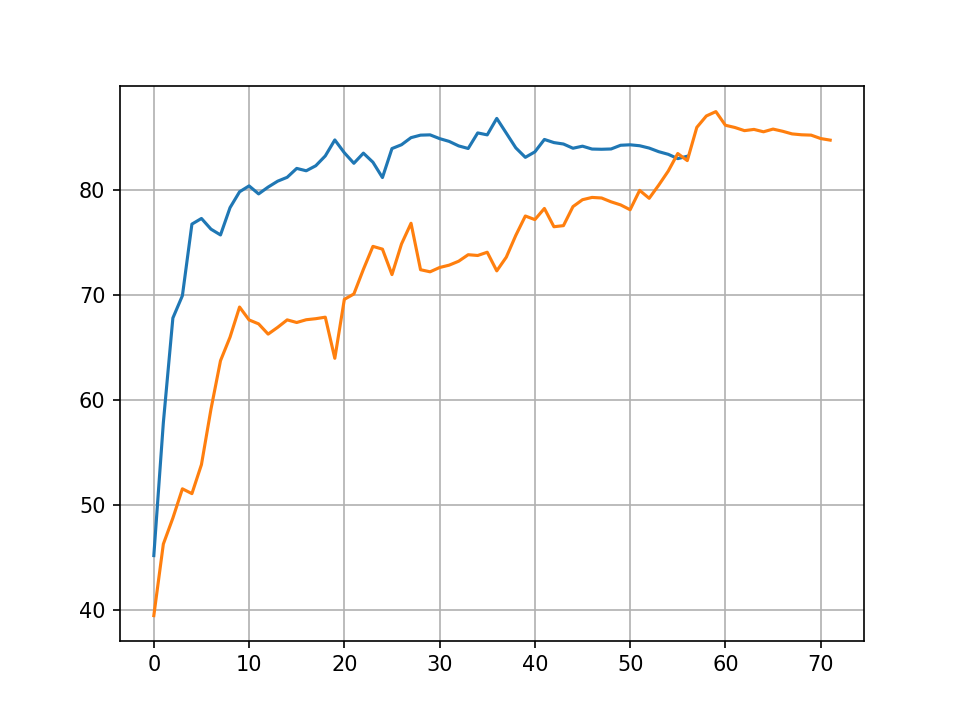

In [10]:
fig, ax = plt.subplots()
ax.plot(total_ratings[254])
ax.plot(total_ratings[1678])
ax.grid()
fig.show()